In [1435]:
using LinearAlgebra
using Plots
pyplot();

using Pkg
Pkg.activate("../")

using Revise
using ExpFamilyDistributions
using BayesianModels

 Activating environment at `~/BUT/Repositories/myForks/BayesianModels/Project.toml`


### Synthetic data test

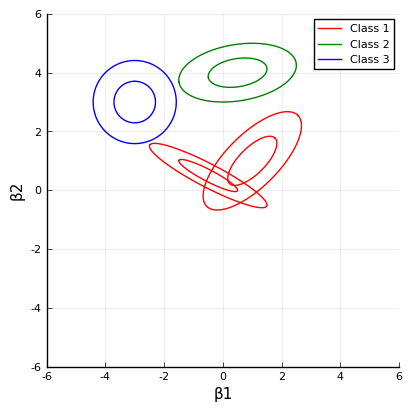

10×1000×5 Array{Float64,3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  

In [1436]:
# Class 1
μ1 = [1., 1.]
Σ1 = [0.7 0.5; 0.5 0.7]

# Class 2
μ2 = [-0.5, 0.5]
Σ2 = [1 -0.5; -0.5 0.3]
μ3 = [0.5, 4.]
Σ3 = 0.5 * [2. 0.25; 0.25 0.5]

# Class 3
μ4 = [-3, 3]
Σ4 = .5 * [1. 0.; 0. 1.]

function samplenormal(μ, Σ, size)
    L = cholesky(Σ).L
    μ .+ L * randn(2, size)
end

sizecoeff = 100

x1_test = hcat(samplenormal(μ1, Σ1, 3* sizecoeff), samplenormal(μ2, Σ2, 2 * sizecoeff))
x2_test = samplenormal(μ3, Σ3, 5  * sizecoeff)
x3_test = samplenormal(μ4, Σ4, 2  * sizecoeff)

X_test = hcat(x1_test, x2_test, x3_test)
z_test = vcat(ones(Int64, size(x1_test, 2)), ones(Int64, size(x2_test, 2)) * 2,  
         ones(Int64, size(x3_test, 2)) * 3)


function plotdata!(p, x1_test, x2_test, x3_test)
    scatter!(p, x1_test[1, :], x1_test[2, :], label=nothing, marker = (:diamond, 5, 0.5, :red, stroke(0)))
    scatter!(p, x2_test[1, :], x2_test[2, :], label=nothing, marker = (:circle, 5, 0.5, :green, stroke(0)))
    scatter!(p, x3_test[1, :], x3_test[2, :], label=nothing, marker = (:utriangle, 5, 0.5, :blue, stroke(0)))
end

p = plot(size=(500, 500), xlims=(-6, 6), ylims=(-6, 6))
plotdata!(p, x1_test, x2_test, x3_test)

savefig("plots/test.png")


# Plot of distribution
ppost_dist = plot(xlims = (-6, 6), ylims = (-6, 6),
              aspect_ratio=:equal, xlabel = "β1",
              ylabel = "β2")
plotnormal2d(ppost_dist, μ1, Σ1, ncontours = 2, color = :red, label="Class 1")
plotnormal2d(ppost_dist, μ2, Σ2, ncontours = 2, color = :red)
plotnormal2d(ppost_dist, μ3, Σ3, ncontours = 2, color = :green, label="Class 2")
plotnormal2d(ppost_dist, μ4, Σ4, ncontours = 2, color = :blue, label="Class 3")
savefig("plots/distribution.png")



# For plotting
nsteps = 1000
accs_all = zeros(Float64, 10, nsteps, 5)
xentropy_all = zeros(Float64, 10, nsteps, 5)

## Synthetic data train

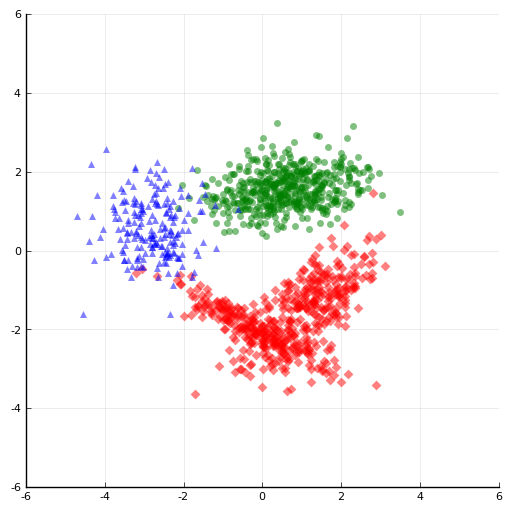

In [1669]:
# Class 1
μ1 = [1., 1.]
Σ1 = [0.7 0.5; 0.5 0.7]

# Class 2
μ2 = [-0.5, 0.5]
Σ2 = [1 -0.5; -0.5 0.3]
μ3 = [0.5, 4.]
Σ3 = 0.5 * [2. 0.25; 0.25 0.5]

# Class 3
μ4 = [-3, 3]
Σ4 = .5 * [1. 0.; 0. 1.]

function samplenormal(μ, Σ, size)
    L = cholesky(Σ).L
    μ .+ L * randn(2, size)
end

sizecoeff = 9

x1_train = hcat(samplenormal(μ1, Σ1, 3* sizecoeff), samplenormal(μ2, Σ2, 2 * sizecoeff))
x2_train = samplenormal(μ3, Σ3, 5  * sizecoeff)
x3_train = samplenormal(μ4, Σ4, 2  * sizecoeff)

X_train = hcat(x1_train, x2_train, x3_train)
z_train = vcat(ones(Int64, size(x1_train, 2)), ones(Int64, size(x2_train, 2)) * 2,  
         ones(Int64, size(x3_train, 2)) * 3)


# Normalize both train and test with respect to the mean of train
train_mean = Statistics.mean(X_train, dims=2)
X_train .-= train_mean
X_test_norm = X_test .- train_mean
x1_train .-= train_mean
x2_train .-= train_mean
x3_train .-= train_mean
x1_test_norm = x1_test .- train_mean
x2_test_norm = x2_test .- train_mean
x3_test_norm = x3_test .- train_mean


function plotdata!(p, x1_train, x2_train, x3_train)
    scatter!(p, x1_train[1, :], x1_train[2, :], label=nothing, marker = (:diamond, 5, 0.5, :red, stroke(0)))
    scatter!(p, x2_train[1, :], x2_train[2, :], label=nothing, marker = (:circle, 5, 0.5, :green, stroke(0)))
    scatter!(p, x3_train[1, :], x3_train[2, :], label=nothing, marker = (:utriangle, 5, 0.5, :blue, stroke(0)))
end

p = plot(size=(500, 500), xlims=(-6, 6), ylims=(-6, 6))
plotdata!(p, x1_train, x2_train, x3_train)


optim = "SGD"

savefig("plots/"*optim*"/train_"*string(sizecoeff)*".png")


p = plot(size=(500, 500), xlims=(-6, 6), ylims=(-6, 6))
plotdata!(p, x1_test_norm, x2_test_norm, x3_test_norm)

savefig("plots/"*optim*"/test_norm.png")


### Model initialization

In [1670]:
model = LogisticRegression(inputdim = 2, nclasses = 3, pseudocounts = 1, hasbias = true)

LogisticRegression{3}(
  (stickbreaking): [
    (1) BinaryLogisticRegression(
      (β): ConjugateParameter{Normal{Float64,3}}
    )
    (2) BinaryLogisticRegression(
      (β): ConjugateParameter{Normal{Float64,3}}
    )
  ]
)


### Training

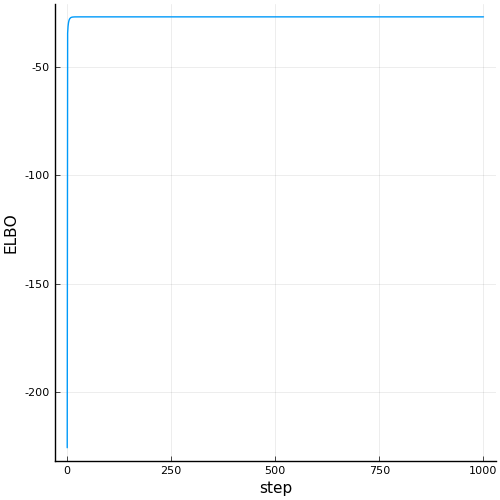

In [1671]:
function accuracy_PG(model, X, z)
    p = predict(model,X)'
    maxpred = mapslices(argmax, p, dims=2)[:,1]
    sum(maxpred .== z) / length(z)
end


function cross_entropy_PG(model, X, z)
    p = predict(model,X)'
    onehot = zeros(Float64, size(z,1), n_classes)
    for i = 1:n_classes
        onehot[:,i] = (z .== i)
    end
    -sum(log.(p) .* onehot) / length(z)
end


# Number of training step. One step will update both the β and ω parameter.
elbos = [elbo(model, X_train, z_train)]
accs = [accuracy_PG(model, X_test_norm, z_test)]
xentropy = [cross_entropy_PG(model, X_test_norm, z_test)]

for step in 1:nsteps    
    for param in getconjugateparams(model)
        stats = (X_train, z_train) |> param.stats
        accstats = dropdims(sum(stats, dims = 2), dims=2)
        update!(param.posterior, naturalparam(param.prior) + accstats)
    end
    
    # This is just for monitoring, not actually needed for training.
    push!(elbos, elbo(model, X_train, z_train))
    push!(accs, accuracy_PG(model, X_test_norm, z_test))
    push!(xentropy, cross_entropy_PG(model, X_test_norm, z_test))
end

ptraining = plot(
    0:nsteps, elbos,
    size=(500, 500),
    xlabel="step",
    ylabel="ELBO",
    legend=false
)

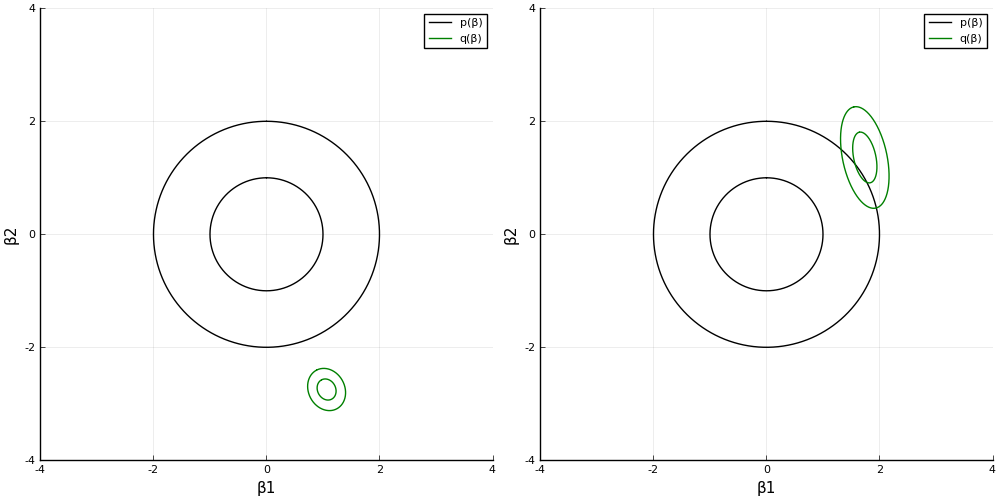

In [1672]:
l = @layout [a b]
ppost1 = plot(xlims = (-4, 4), ylims = (-4, 4),
              aspect_ratio=:equal, xlabel = "β1",
              ylabel = "β2")

μ₀ = model.stickbreaking[1].β.prior.μ
Σ₀ = model.stickbreaking[1].β.prior.Σ
μᵦ = model.stickbreaking[1].β.posterior.μ
Σᵦ = model.stickbreaking[1].β.posterior.Σ
plotnormal2d(ppost1, μ₀[1:2], Σ₀[1:2, 1:2], ncontours = 2, color = :black, label="p(β)")
plotnormal2d(ppost1, μᵦ[1:2], Σᵦ[1:2, 1:2], ncontours = 2, color = :green, label="q(β)")

ppost2 = plot(xlims = (-4, 4), ylims = (-4, 4),
              aspect_ratio=:equal, xlabel = "β1",
              ylabel = "β2")
μ₀ = model.stickbreaking[2].β.prior.μ
Σ₀ = model.stickbreaking[2].β.prior.Σ
μᵦ = model.stickbreaking[2].β.posterior.μ
Σᵦ = model.stickbreaking[2].β.posterior.Σ
plotnormal2d(ppost2, μ₀[1:2], Σ₀[1:2, 1:2], ncontours = 2, color = :black, label="p(β)")
plotnormal2d(ppost2, μᵦ[1:2], Σᵦ[1:2, 1:2], ncontours = 2, color = :green, label="q(β)")


plot(ppost1, ppost2, layout = l, size = (1000, 500))

### Visualisation

In [1673]:
function sampleβ(μ, Σ)
    L = cholesky(Σ).L
    μ .+ L * randn(length(μ))
end

function plotdecisionline!(p, w, w₀; plotting_radius=20, args...)
    # Normalize vector of weights
    norm_w = w ./ sqrt(sum(w.^2))

    # Angle of the weight vector in the range [0,2 π]
    θ = atan(w[2], w[1]) + π

    # Vector perpendicular to "w" with unit length.
    w⊥ = [cos(θ + π/2), sin(θ + π/2)]

    # Translation vector of  the decision boundary induced
    # by the bias
    shift = -(w₀ / sqrt(sum(w.^2))) * norm_w

    # Angle of the decision line in the range [0, 2π]
    α = atan(w⊥[2], w⊥[1]) + π
    
    # To get the decision line we rotate and shift the 
    # abscissa
    R = [cos(α) -sin(α); sin(α) cos(α)]
    decisionline = vcat(range(-plotting_radius, plotting_radius, length=1000)', zeros(1000)') 
    decisionline = R * decisionline .+ shift
    
    plot!(p, decisionline[1, :], decisionline[2, :]; args...)
end

plotdecisionline! (generic function with 1 method)

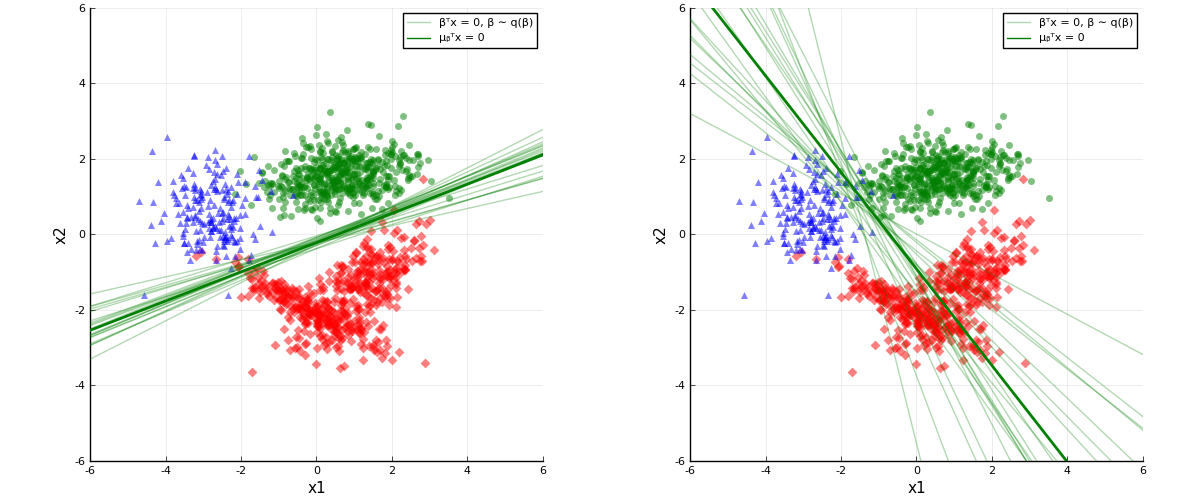

In [1674]:
μᵦ = model.stickbreaking[1].β.posterior.μ
Σᵦ = model.stickbreaking[1].β.posterior.Σ

pdec1 = plot(
    size=(500, 500),
    aspect_ratio=:equal,
    xlims=(-6, 6),
    ylims=(-6, 6),
    xlabel="x1", 
    ylabel="x2"
)

plotdata!(pdec1, x1_test_norm, x2_test_norm, x3_test_norm)

for i in 1:20
    sβ = sampleβ(μᵦ, Σᵦ)
    w = sβ[1:2]
    w₀ = model.stickbreaking[1].hasbias ? sβ[end] : 0. 
    
    label = i > 1 ? "" : "βᵀx = 0, β ∼ q(β)" 
    plotdecisionline!(pdec1, w, w₀, line = (:green, 0.3), label=label)
end

w = μᵦ[1:2]
w₀ = model.stickbreaking[1].hasbias ? μᵦ[end] : 0.
plotdecisionline!(pdec1, w, w₀, line = (:green), linewidth=2, label="μᵦᵀx = 0")


###################################################

μᵦ = model.stickbreaking[2].β.posterior.μ
Σᵦ = model.stickbreaking[2].β.posterior.Σ

pdec2 = plot(
    size=(500, 500),
    aspect_ratio=:equal,
    xlims=(-6, 6),
    ylims=(-6, 6),
    xlabel="x1", 
    ylabel="x2"
)

plotdata!(pdec2, x1_test_norm, x2_test_norm, x3_test_norm)

for i in 1:20
    sβ = sampleβ(μᵦ, Σᵦ)
    w = sβ[1:2]
    w₀ = model.stickbreaking[2].hasbias ? sβ[end] : 0. 
    
    label = i > 1 ? "" : "βᵀx = 0, β ∼ q(β)" 
    plotdecisionline!(pdec2, w, w₀, line = (:green, 0.3), label=label)
end

w = μᵦ[1:2]
w₀ = model.stickbreaking[2].hasbias ? μᵦ[end] : 0.
plotdecisionline!(pdec2, w, w₀, line = (:green), linewidth=2, label="μᵦᵀx = 0")

l = @layout [a b]
plot(pdec1, pdec2, layout = l, size = (1200, 500))

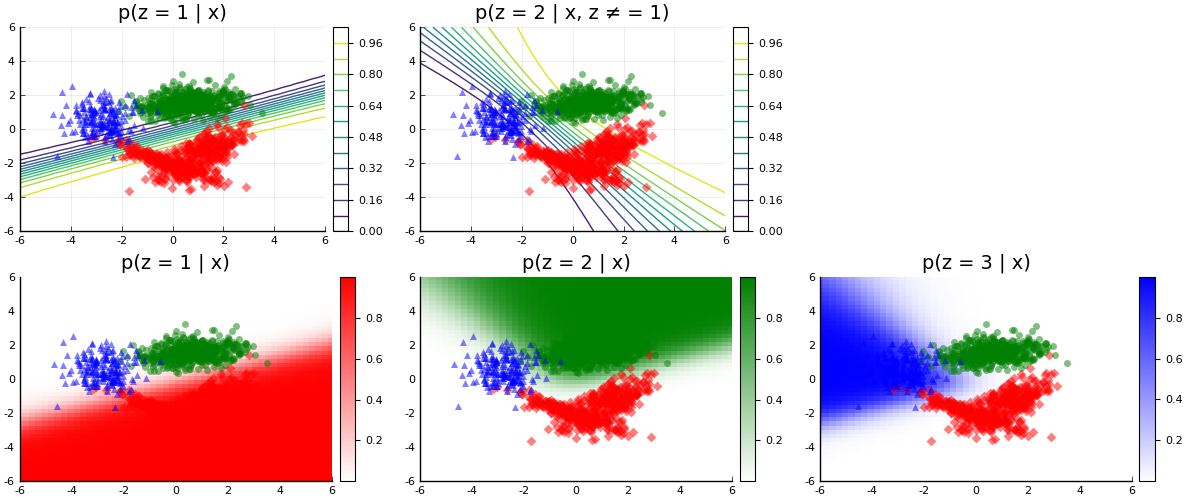

In [1675]:
# Resolution for plotting the decision region
res = 50

# Generate a grid of the input space
dim1 = range(-6, 6, length=res)
dim2 = range(-6, 6, length=res)
testX = vec([ [i, j] for i=dim1, j=dim2])
testX = hcat(testX...)

# Prediction of the model in a KxN array
pz = reshape(predict(model, testX), :, res, res)

# Prediction of the stick-breaking process (just for plotting not used in practice)
pz1 = reshape(predict(model.stickbreaking[1], testX), res, res)
pz2_z1 = reshape(predict(model.stickbreaking[2], testX), res, res)

#################################
# Plotting p(z = 1 | x)

ppredict1 = heatmap(
    title = "p(z = 1 | x)",
    dim1, 
    dim2,
    pz[1, :, :]',
    xlims = (-6, 6),
    ylims = (-6, 6),
    c = cgrad([:white, :red])
)
plotdata!(ppredict1, x1_test_norm, x2_test_norm, x3_test_norm)


ppredict1_1 = plot(
    title = "p(z = 1 | x)",
    dim1, 
    dim2,
    pz1',
    xlims = (-6, 6),
    ylims = (-6, 6),
    c = :viridis
)
plotdata!(ppredict1_1, x1_test_norm, x2_test_norm, x3_test_norm)

#################################
# Plotting p(z = 3 | x) and p(z = 2 | x, z ≠ 1)

ppredict2 = heatmap(
    title = "p(z = 2 | x)",
    dim1, 
    dim2,
    pz[2, :, :]',
    xlims = (-6, 6),
    ylims = (-6, 6),
    c = cgrad([:white, :green])
)
plotdata!(ppredict2, x1_test_norm, x2_test_norm, x3_test_norm)

ppredict2_1 = plot(
    title = "p(z = 2 | x, z ≠ = 1)",
    dim1, 
    dim2,
    pz2_z1',
    xlims = (-6, 6),
    ylims = (-6, 6),
    c = :viridis
)
plotdata!(ppredict2_1, x1_test_norm, x2_test_norm, x3_test_norm)

#################################
# Plotting p(z = 3 | x)

ppredict3 = heatmap(
    title = "p(z = 3 | x)",
    dim1, 
    dim2,
    pz[3, :, :]',
    xlims = (-6, 6),
    ylims = (-6, 6),
    #c = :viridis
    c = cgrad([:white, :blue])
)
plotdata!(ppredict3, x1_test_norm, x2_test_norm, x3_test_norm)


ppredict3_12 = plot(legend=false,grid=false,foreground_color_subplot=:white)  # create subplot to be blank

l = @layout [a b c; d e f]
plot(ppredict1_1, ppredict2_1, ppredict3_12, ppredict1, ppredict2, ppredict3, layout = l, size = (1200, 500))

# Using Logistic Regression trained with Maximum Likelihood Estimate

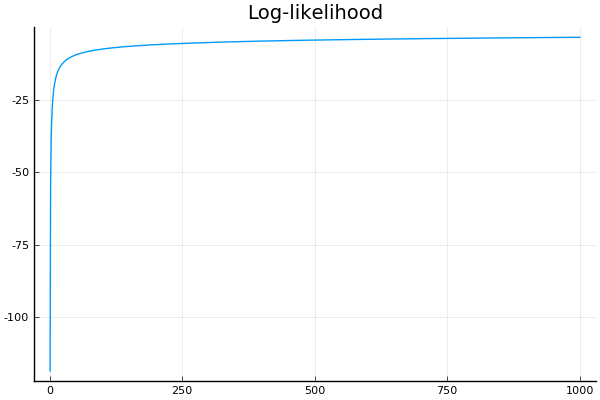

In [1676]:
# Using Logistic Regression

function σ(x)
    1 / (1 + exp(-x))
end

function encode(z, n_classes)
    # For the purpose of operating with matrices the function encodes the vector of classes as:
    # onehot: one-hot encoding for the classes, where the class 'n_classes' is encoded as all 0's
    # N_up_to: for each sample of class c, row i is 1 if i>=c and 0 otherwise. Note that if c=n_classes, all rows are 0's
    
    onehot = zeros(Int64, n_classes - 1, length(z))
    for i = 1:n_classes-1
        onehot[i, z .== i] .= 1
    end

    N_up_to = zeros(Int64, n_classes - 1, length(z))
    for i = 1:n_classes-1
        N_up_to[i, z .> i] .= 1
    end

    onehot, N_up_to
end


function deriv_sig(β, x)
    (1 .- σ.(β*x)) * x'
end


function deriv_comp_sig(β, x)
    .- σ.(β*x) * x'
end


function loglikelihood(n_classes, z, X, β)
    ν = σ.(β*X)
    onehot, N_up_to = encode(z, n_classes)
    sum(diag(onehot' * log.(ν) .+ N_up_to' * log.(1 .- ν)))
end

function predict_MLE(β, X)
    X_augmented = [X; ones(Float64, 1, size(X, 2))]
    ν = σ.(X_augmented' * β')
    comp_ν = 1 .- ν
    π = zeros(Float64, size(ν, 1), size(ν, 2)+1)
    π[:, 1] = ν[:, 1]
    for i = 2:size(ν, 2)
        π[:, i] = ν[:, i] .* prod(comp_ν[:, 1:i-1], dims=2)[:, 1]
    end
    π[:, size(π, 2)] = prod(comp_ν, dims=2)[:, 1]
    return π
end


function accuracy_MLE(β, X, z)
    p = predict_MLE(β,X)
    maxpred = mapslices(argmax, p, dims=2)[:,1]
    sum(maxpred .== z) / length(z)
end


function cross_entropy_MLE(β, X, z)
    p = predict_MLE(β,X)
    onehot = zeros(Float64, size(z,1), n_classes)
    for i = 1:n_classes
        onehot[:,i] = (z .== i)
    end
    -sum(log.(p) .* onehot) / length(z)
end


n_classes = 3
β = zeros(Float64, n_classes-1, size(X_train, 1)+1) # +1 to account for the bias

X_train_augmented = [X_train; ones(Float64, 1, size(X_train, 2))] # add 1's to account for the bias

onehot, N_up_to = encode(z_train, n_classes)
η = 0.01

# Contains terms of derivative corresponding to log(σ(β'x_d)) for data point x_d
deriv_sig_for_all = zeros(size(β, 1), size(X_train_augmented, 2), size(X_train_augmented, 1))
# Contains terms of derivative corresponding to log(1 - σ(β'x_d)) for data point x_d
deriv_comp_sig_for_all = zeros(size(β, 1), size(X_train_augmented, 2), size(X_train_augmented, 1))

steps = nsteps
llks_MLE = zeros(steps+1)
accs_MLE = zeros(steps+1)
xentropy_MLE = zeros(steps+1)
llks_MLE[1] = loglikelihood(n_classes, z_train, X_train_augmented, β)
accs_MLE[1] = accuracy_MLE(β, X_test_norm, z_test)
xentropy_MLE[1] = cross_entropy_MLE(β, X_test_norm, z_test)

for step = 1:steps
    # Populate for all data points
    for d = 1:size(X_train_augmented, 2)
        deriv_sig_for_all[:, d, :] = deriv_sig(β, X_train_augmented[:,d])
        deriv_comp_sig_for_all[:, d, :] = deriv_comp_sig(β, X_train_augmented[:,d])
    end
    # Update parameters
    derivatives = sum(onehot .* deriv_sig_for_all .+ N_up_to .* deriv_comp_sig_for_all, dims=2)[:,1,:]
    if optim == "SGD"
        β = β + η * derivatives
    elseif optim == "Adam"
        if !(@isdefined m)
            m = zeros(Float64, size(derivatives, 1), size(derivatives, 2))
            v = zeros(Float64, size(derivatives, 1), size(derivatives, 2))
        end
        ϵ = 1e-8
        β_1 = 0.9
        β_2 = 0.999
        m = β_1 * m .+ (1-β_1) * derivatives
        v = β_2 * v .+ (1-β_2) * derivatives.^2
        m̂ = m ./ (1 - β_1^step)
        v̂ = v ./ (1 - β_2^step)
        β = β + η * m̂ ./ (sqrt.(v̂) .+ ϵ)
    end
    
    llks_MLE[step+1] = loglikelihood(n_classes, z_train, X_train_augmented, β)
    accs_MLE[step+1] = accuracy_MLE(β, X_test_norm, z_test)
    xentropy_MLE[step+1] = cross_entropy_MLE(β, X_test_norm, z_test)
end

β_MLE = β
llk_plot = plot(1:steps+1, llks_MLE, label="llk", title = "Log-likelihood")
plot(llk_plot, legend=false)



### Compute accuracy

In [1677]:
print("Accuracy: $(100*accuracy_MLE(β, X_test_norm, z_test))%\n")
print("Cross entropy: $(100*cross_entropy_MLE(β, X_test_norm, z_test))%\n")

Accuracy: 98.08333333333333%
Cross entropy: 6.624190679098755%


### Plot output of MLE LR

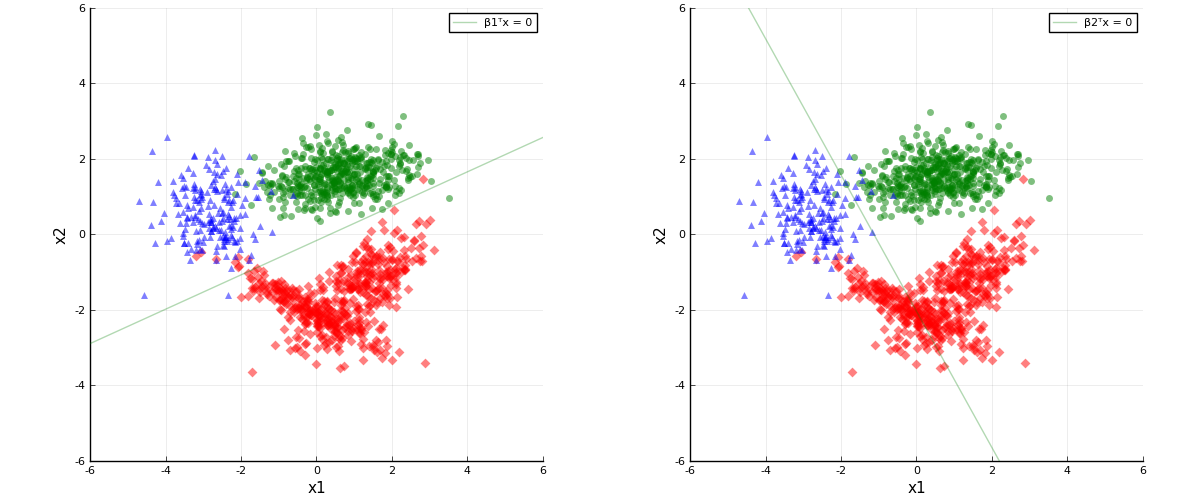

In [1678]:
pdec1 = plot(
    size=(500, 500),
    aspect_ratio=:equal,
    xlims=(-6, 6),
    ylims=(-6, 6),
    xlabel="x1", 
    ylabel="x2"
)

plotdata!(pdec1, x1_test_norm, x2_test_norm, x3_test_norm)

w = β[1, 1:size(X_test_norm,1)]
w₀ = β[1, size(X_test_norm,1)+1]

label = "β1ᵀx = 0" 
plotdecisionline!(pdec1, w, w₀, line = (:green, 0.3), label=label)


###################################################

pdec2 = plot(
    size=(500, 500),
    aspect_ratio=:equal,
    xlims=(-6, 6),
    ylims=(-6, 6),
    xlabel="x1", 
    ylabel="x2"
)

plotdata!(pdec2, x1_test_norm, x2_test_norm, x3_test_norm)

w = β[2, 1:size(X_test_norm,1)]
w₀ = β[2, size(X_test_norm,1)+1] 
    
label = "β2ᵀx = 0" 
plotdecisionline!(pdec2, w, w₀, line = (:green, 0.3), label=label)


###################################################

l = @layout [a b]
plot(pdec1, pdec2, layout = l, size = (1200, 500))

## Bayesian Logistic Regression (reparameterization trick)

In [ ]:
# Using Logistic Regression

function deriv_sig_mean(μ, λ, ϵ, x)
    (1 .- σ.((μ + exp.(.5 * λ).*ϵ) * x)) .* x'
end


function deriv_comp_sig_mean(μ, λ, ϵ, x)
    .- σ.((μ + exp.(.5 * λ).*ϵ) * x) .* x'
end


function deriv_sig_cov(μ, λ, ϵ, x)
    (1 .- σ.((μ + exp.(.5 * λ).*ϵ) * x)) .* (ϵ' .* x)' * 0.5
end


function deriv_comp_sig_cov(μ, λ, ϵ, x)
    .- σ.((μ + exp.(.5 * λ).*ϵ) * x) .* (ϵ' .* x)' * 0.5
end


function loglikelihood(n_classes, z, X, μ, λ)
    ν = zeros(Float64, n_classes-1, size(X, 2))
    for i = 1:(n_classes-1)
        ϵi = randn(size(μ, 2))
        βi = μ[i,:] + exp.(.5 * λ[i,:]) .* ϵi
        ν[i, :] = σ.(βi'*X)
    end
    onehot, N_up_to = encode(z, n_classes)
    logParams = log.(ν)
    logComplementParams = log.(1 .- ν)
    sum(diag(onehot' * logParams .+ N_up_to' * logComplementParams))
end


function KL_divergence(μ, λ)
    sum(0.5 .* sum(exp.(λ) .+ μ.^2 .- λ .- 1))
end


# Predict the classes using the Maximum A Posteriori (MAP) parameters
function predict_map(μ, X::Matrix{T}) where T <: AbstractFloat
    X_augmented = [X; ones(Float64, 1, size(X, 2))]
    ν = σ.(X_augmented' * μ')
    comp_ν = 1 .- ν
    π = zeros(Float64, size(ν, 1), size(ν, 2)+1)
    π[:, 1] = ν[:, 1]
    for i = 2:size(ν, 2)
        π[:, i] = ν[:, i] .* prod(comp_ν[:, 1:i-1], dims=2)[:, 1]
    end
    π[:, size(π, 2)] = prod(comp_ν, dims=2)[:, 1]
    return π
end


function accuracy_map(μ, X, z)
    p = predict_map(μ, X)
    maxpred = mapslices(argmax, p, dims=2)[:,1]
    sum(maxpred .== z) / length(z)
end


function predict_marginal(μ, λ, X)
    # Following https://arxiv.org/pdf/1703.00091.pdf, we use the
    # approximation:
    # ⟨σ(ψ)⟩ ≈ σ(μ / √(1 + a * σ²))
    # where a = 0.368
    a = 0.368
    # In Bishop 4.5.2 a very similar approximation uses a = π / 8 ≈ 0.392...
    X_augmented = [X; ones(Float64, 1, size(X, 2))]
    Σ = zeros(Float64, size(λ, 1), size(λ, 2), size(λ, 2))
    ν = zeros(Float64, size(X, 2), size(μ, 1))
    for i = 1:size(λ, 1)
        Σ[i,:,:] = diagm(exp.(λ[i,:]))
        E_ββᵀ = Σ[i,:,:] + μ[i,:] * μ[i,:]'
        ψ_μ = X_augmented' * μ[i,:]
        ψ² = dropdims(sum(X_augmented .* (E_ββᵀ * X_augmented), dims = 1), dims = 1)
        ψ_σ² = ψ² .- (ψ_μ .^ 2)
        y = ψ_μ ./ sqrt.(1 .+ a * ψ_σ²)
        ν[:,i] = 1 ./ (1 .+ exp.(-y))
    end
    
    comp_ν = 1 .- ν
    π = zeros(Float64, size(ν, 1), size(ν, 2)+1)
    π[:, 1] = ν[:, 1]
    for i = 2:size(ν, 2)
        π[:, i] = ν[:, i] .* prod(comp_ν[:, 1:i-1], dims=2)[:, 1]
    end
    π[:, size(π, 2)] = prod(comp_ν, dims=2)[:, 1]
    return π
end


function accuracy_marginal(μ, λ, X, z)
    p = predict_marginal(μ, λ, X)
    maxpred = mapslices(argmax, p, dims=2)[:,1]
    sum(maxpred .== z) / length(z)
end


function cross_entropy_marginal(μ, λ, X, z)
    p = predict_marginal(μ, λ, X)
    onehot = zeros(Float64, size(z,1), n_classes)
    for i = 1:n_classes
        onehot[:,i] = (z .== i)
    end
    -sum(log.(p) .* onehot) / length(z)
end


n_classes = 3

# Parameters of the model
μ = zeros(Float64, n_classes-1, size(X_train, 1)+1) # +1 to account for the bias
λ = ones(Float64, n_classes-1, size(X_train, 1)+1) # +1 to account for the bias
             # since the covariance matrix is diagonal, 
             # only the elements in the diagonal are modeled. 
             # Also, in order to have a positive definite matrix, 
             # the elements of the diagonal of Σ1 are exp.{λ1}

X_train_augmented = [X_train; ones(Float64, 1, size(X_train, 2))] # add 1's to account for the bias

onehot, N_up_to = encode(z_train, n_classes)
η = 0.01

L = 10 # number of samples to use

# Contains terms of derivative of mean corresponding to log(σ(β'x_d)) for data point x_d and sample l
deriv_sig_for_all_mean = zeros(size(β, 1), size(X_train_augmented, 2), size(X_train_augmented, 1), L)
# Contains terms of derivative of covariance corresponding to log(σ(β'x_d)) for data point x_d and sample l
deriv_sig_for_all_cov = zeros(size(β, 1), size(X_train_augmented, 2), size(X_train_augmented, 1), L)

# Contains terms of derivative of mean corresponding to log(1 - σ(β'x_d)) for data point x_d and sample l
deriv_comp_sig_for_all_mean = zeros(size(β, 1), size(X_train_augmented, 2), size(X_train_augmented, 1), L)
# Contains terms of derivative of mean corresponding to log(1 - σ(β'x_d)) for data point x_d and sample l
deriv_comp_sig_for_all_cov = zeros(size(β, 1), size(X_train_augmented, 2), size(X_train_augmented, 1), L)

llk = loglikelihood(n_classes, z_train, X_train_augmented, μ, λ)
Dkl = KL_divergence(μ, λ)

steps = nsteps
llks = zeros(Float64, steps+1)
Dkls = zeros(Float64, steps+1)
elbo_reparam_diag = zeros(Float64, steps+1)
accs_map_reparam_diag = zeros(Float64, steps+1)
accs_marginal_reparam_diag = zeros(Float64, steps+1)
xentropy_marginal_reparam_diag = zeros(Float64, steps+1)
llks[1] = llk
Dkls[1] = Dkl
elbo_reparam_diag[1] = llk - Dkl
accs_map_reparam_diag[1] = accuracy_map(μ, X_test_norm, z_test)
accs_marginal_reparam_diag[1] = accuracy_marginal(μ, λ, X_test_norm, z_test)
xentropy_marginal_reparam_diag[1] = cross_entropy_marginal(μ, λ, X_test_norm, z_test)

for step = 1:steps    
    # Populate for all data points and samples
    for l = 1:L
        ϵl = randn(n_classes-1, size(X_train, 1)+1)
        for d = 1:size(X_train_augmented, 2)
            deriv_sig_for_all_mean[:, d, :, l] = deriv_sig_mean(μ, λ, ϵl, X_train_augmented[:,d])
            deriv_comp_sig_for_all_mean[:, d, :, l] = deriv_comp_sig_mean(μ, λ, ϵl, X_train_augmented[:,d])
            deriv_sig_for_all_cov[:, d, :, l] = deriv_sig_cov(μ, λ, ϵl, X_train_augmented[:,d])
            deriv_comp_sig_for_all_cov[:, d, :, l] = deriv_comp_sig_cov(μ, λ, ϵl, X_train_augmented[:,d])
        end
    end
    
    # Update parameters
    derivatives_mean = 1.0/L .* sum(onehot .* deriv_sig_for_all_mean .+ N_up_to .* deriv_comp_sig_for_all_mean, dims=[2,4])[:,1,:,1]
    # Subtract KL divergence term
    derivatives_mean .-= μ
    if optim == "SGD"
        μ = μ + η * derivatives_mean
    elseif optim == "Adam"
        if !(@isdefined m_μ)
            m_μ = zeros(Float64, size(derivatives_mean, 1), size(derivatives_mean, 2))
            v_μ = zeros(Float64, size(derivatives_mean, 1), size(derivatives_mean, 2))
        end
        ϵ_μ = 1e-8
        β_1 = 0.9
        β_2 = 0.999
        m_μ = β_1 * m_μ .+ (1-β_1) * derivatives_mean
        v_μ = β_2 * v_μ .+ (1-β_2) * derivatives_mean.^2
        m̂_μ = m_μ ./ (1 - β_1^step)
        v̂_μ = v_μ ./ (1 - β_2^step)
        μ = μ + η * m̂_μ ./ (sqrt.(v̂_μ) .+ ϵ_μ)
    end
     
    derivatives_cov = 1.0/L .* sum(onehot .* deriv_sig_for_all_cov .+ N_up_to .* deriv_comp_sig_for_all_cov, dims=[2,4])[:,1,:,1]
    # Subtract KL divergence term
    derivatives_cov .-= 0.5 .* (exp.(λ) .- 1)
    if optim == "SGD"
        λ = λ + η * derivatives_cov
    elseif optim == "Adam"
        if !(@isdefined m_λ)
            m_λ = zeros(Float64, size(derivatives_cov, 1), size(derivatives_cov, 2))
            v_λ = zeros(Float64, size(derivatives_cov, 1), size(derivatives_cov, 2))
        end
        ϵ_λ = 1e-8
        β_1 = 0.9
        β_2 = 0.999
        m_λ = β_1 * m_λ .+ (1-β_1) * derivatives_cov
        v_λ = β_2 * v_λ .+ (1-β_2) * derivatives_cov.^2
        m̂_λ = m_λ ./ (1 - β_1^step)
        v̂_λ = v_λ ./ (1 - β_2^step)
        λ = λ + η * m̂_λ ./ (sqrt.(v̂_λ) .+ ϵ_λ)
    end
    
    llk = loglikelihood(n_classes, z_train, X_train_augmented, μ, λ)
    Dkl = KL_divergence(μ, λ)
    llks[step+1] = llk
    Dkls[step+1] = Dkl
    elbo_reparam_diag[step+1] = llk - Dkl
    accs_map_reparam_diag[step+1] = accuracy_map(μ, X_test_norm, z_test)
    accs_marginal_reparam_diag[step+1] = accuracy_marginal(μ, λ, X_test_norm, z_test)
    xentropy_marginal_reparam_diag[step+1] = cross_entropy_marginal(μ, λ, X_test_norm, z_test)
end

β_reparam_diag_map = μ
μ_reparam_diag = μ
λ_reparam_diag = λ
llk_plot = plot(1:steps+1, llks, label="llk", title = "Log-likelihood")
Dkl_plot = plot(1:steps+1, Dkls, label="Dkl", title = "KL divergence")
elbo_plot = plot(1:steps+1, llks-Dkls, label="ELBO", title = "ELBO")
plot(llk_plot, Dkl_plot, elbo_plot, layout = (3,1), legend=false)

In [ ]:
print("Accuracy MAP: $(100*accuracy_map(μ, X_test_norm, z_test))%\n")
print("Accuracy marginal: $(100*accuracy_marginal(μ, λ, X_test_norm, z_test))%\n")
print("Cross entropy marginal: $(100*cross_entropy_marginal(μ, λ, X_test_norm, z_test))%\n")

### Plot output of Bayesian LR with reparameterization trick

In [ ]:
pdec1 = plot(
    size=(500, 500),
    aspect_ratio=:equal,
    xlims=(-6, 6),
    ylims=(-6, 6),
    xlabel="x1", 
    ylabel="x2"
)

plotdata!(pdec1, x1_test_norm, x2_test_norm, x3_test_norm)

for i in 1:20
    ϵ1 = randn(size(X_test_norm, 1)+1)
    β1 = μ[1,:] + diagm(exp.(.5 * λ[1,:])) * ϵ1
    
    w = β1[1:size(X_test_norm,1)]
    w₀ = β1[size(X_test_norm,1)+1]
    
    label = i > 1 ? "" : "β1ᵀx = 0, β1 ∼ q(β1)" 
    plotdecisionline!(pdec1, w, w₀, line = (:green, 0.3), label=label)
end

w = μ[1,1:size(X_test_norm,1)]
w₀ = μ[1,size(X_test_norm,1)+1]
plotdecisionline!(pdec1, w, w₀, line = (:green), linewidth=2, label="μᵦᵀx = 0")


###################################################

pdec2 = plot(
    size=(500, 500),
    aspect_ratio=:equal,
    xlims=(-6, 6),
    ylims=(-6, 6),
    xlabel="x1", 
    ylabel="x2"
)

plotdata!(pdec2, x1_test_norm, x2_test_norm, x3_test_norm)

for i in 1:20
    ϵ2 = randn(size(X_test_norm, 1)+1)
    β2 = μ[2,:] + diagm(exp.(.5 * λ[2,:])) * ϵ2
    
    w = β2[1:size(X_test_norm,1)]
    w₀ = β2[size(X_test_norm,1)+1]
    
    label = i > 1 ? "" : "β2ᵀx = 0, β2 ∼ q(β2)" 
    plotdecisionline!(pdec2, w, w₀, line = (:green, 0.3), label=label)
end

w = μ[2,1:size(X_test_norm,1)]
w₀ = μ[2,size(X_test_norm,1)+1]
plotdecisionline!(pdec2, w, w₀, line = (:green), linewidth=2, label="μᵦᵀx = 0")

l = @layout [a b]
plot(pdec1, pdec2, layout = l, size = (1200, 500))

In [ ]:
l = @layout [a b]
ppost1 = plot(xlims = (-4, 4), ylims = (-4, 4),
              aspect_ratio=:equal, xlabel = "β1",
              ylabel = "β2")

μ₀ = model.stickbreaking[1].β.prior.μ
Σ₀ = model.stickbreaking[1].β.prior.Σ
μᵦ = model.stickbreaking[1].β.posterior.μ
Σᵦ = model.stickbreaking[1].β.posterior.Σ
plotnormal2d(ppost1, μ₀[1:2], Σ₀[1:2, 1:2], ncontours = 2, color = :black, label="p(β)")
plotnormal2d(ppost1, μᵦ[1:2], Σᵦ[1:2, 1:2], ncontours = 2, color = :green, label="q(β)")
plotnormal2d(ppost1, μ[1,1:2], diagm(exp.(λ[1,:]))[1:2, 1:2], ncontours = 2, color = :blue, label="r(β)")



ppost2 = plot(xlims = (-4, 4), ylims = (-4, 4),
              aspect_ratio=:equal, xlabel = "β1",
              ylabel = "β2")
μ₀ = model.stickbreaking[2].β.prior.μ
Σ₀ = model.stickbreaking[2].β.prior.Σ
μᵦ = model.stickbreaking[2].β.posterior.μ
Σᵦ = model.stickbreaking[2].β.posterior.Σ
plotnormal2d(ppost2, μ₀[1:2], Σ₀[1:2, 1:2], ncontours = 2, color = :black, label="p(β)")
plotnormal2d(ppost2, μᵦ[1:2], Σᵦ[1:2, 1:2], ncontours = 2, color = :green, label="q(β)")
plotnormal2d(ppost2, μ[2,1:2], diagm(exp.(λ[2,:]))[1:2, 1:2], ncontours = 2, color = :blue, label="r(β)")




plot(ppost1, ppost2, layout = l, size = (1000, 500))

## Stochastic Gradient Langevin Dynamics (SGLD)

In [ ]:
using Statistics

# Using Logistic Regression

function σ(x)
    1 / (1 + exp(-x))
end


function logσ(x) # approximation
    if x > -30
        return -log(1+exp(-x))
    else
        return -x
    end    
end


function encode(z, n_classes)
    # For the purpose of operating with matrices the function encodes the vector of classes as:
    # onehot: one-hot encoding for the classes, where the class 'n_classes' is encoded as all 0's
    # N_up_to: for each sample of class c, row i is 1 if i>=c and 0 otherwise. Note that if c=n_classes, all rows are 0's
    
    onehot = zeros(Int64, n_classes - 1, length(z))
    for i = 1:n_classes-1
        onehot[i, z .== i] .= 1
    end

    N_up_to = zeros(Int64, n_classes - 1, length(z))
    for i = 1:n_classes-1
        N_up_to[i, z .> i] .= 1
    end

    onehot, N_up_to
end


function deriv_sig(β, x)
    (1 .- σ.(β*x)) * x'
end


function deriv_comp_sig(β, x)
    .- σ.(β*x) * x'
end


function loglikelihood(n_classes, z, X, β)
    onehot, N_up_to = encode(z, n_classes)
    sum(diag(onehot' * logσ.(β*X) .+ N_up_to' * (-β*X + logσ.(β*X))))
end


function predict_SGLD(βs, X)
    πs = zeros(Float64, size(βs, 1), size(X, 2), size(βs, 2)+1)
    for b = 1:size(βs,1)
        X_augmented = [X; ones(Float64, 1, size(X, 2))]
        ν = σ.(X_augmented' * βs[b,:,:]')
        comp_ν = 1 .- ν
        πs[b, :, 1] = ν[:, 1]
        for i = 2:size(ν, 2)
            πs[b, :, i] = ν[:, i] .* prod(comp_ν[:, 1:i-1], dims=2)[:, 1]
        end
        πs[b, :, size(πs, 3)] = prod(comp_ν, dims=2)[:, 1]
    end
    return Statistics.mean(πs, dims=1)[1,:,:]
end


function accuracy_SGLD(βs, X, z)
    p = predict_SGLD(βs,X)
    maxpred = mapslices(argmax, p, dims=2)[:,1]
    sum(maxpred .== z) / length(z)
end


function cross_entropy_SGLD(βs, X, z)
    p = predict_SGLD(βs,X)
    onehot = zeros(Float64, size(z,1), n_classes)
    for i = 1:n_classes
        onehot[:,i] = (z .== i)
    end
    -sum(log.(p) .* onehot) / length(z)
end


n_classes = 3


X_train_augmented = [X_train; ones(Float64, 1, size(X_train, 2))] # add 1's to account for the bias

onehot, N_up_to = encode(z_train, n_classes)
lrate = 0.01

# Contains terms of derivative corresponding to log(σ(β'x_d)) for data point x_d
deriv_sig_for_all = zeros(size(β, 1), size(X_train_augmented, 2), size(X_train_augmented, 1))
# Contains terms of derivative corresponding to log(1 - σ(β'x_d)) for data point x_d
deriv_comp_sig_for_all = zeros(size(β, 1), size(X_train_augmented, 2), size(X_train_augmented, 1))

samples = 10
steps = nsteps
llks_SGLD = zeros(Float64, samples, steps+1)
accs_SGLD = zeros(Float64, steps+1)
xentropy_SGLD = zeros(Float64, steps+1)

βs = zeros(Float64, samples, steps, size(β, 1), size(β, 2))
accs_SGLD[1] = accuracy_SGLD(βs[:,1,:,:], X_test, z_test)
xentropy_SGLD[1] = cross_entropy_SGLD(βs[:,1,:,:], X_test, z_test)
for n = 1:samples
    β = zeros(Float64, n_classes-1, size(X_train, 1)+1) # +1 to account for the bias
    llks_SGLD[n, 1] = loglikelihood(n_classes, z_train, X_train_augmented, β)
    for step = 1:steps
        # Populate for all data points
        for d = 1:size(X_train_augmented, 2)
            deriv_sig_for_all[:, d, :] = deriv_sig(β, X_train_augmented[:,d])
            deriv_comp_sig_for_all[:, d, :] = deriv_comp_sig(β, X_train_augmented[:,d])
        end
        # Update parameters
        ϵ_t = step^(-0.5)
        η_t = sqrt(ϵ_t) * randn(size(β))
        derivatives_loglike = sum(onehot .* deriv_sig_for_all .+ N_up_to .* deriv_comp_sig_for_all, dims=2)[:,1,:]
        derivatives_prior = -β
        β = β + lrate * (0.5 * ϵ_t * (derivatives_loglike + derivatives_prior) + η_t)

        llks_SGLD[n, step+1] = loglikelihood(n_classes, z_train, X_train_augmented, β) + (-0.5) * size(X_train_augmented, 1) * log(2π) - 0.5 * dot(β,β)
        βs[n,step,:,:] = β
    end
end
for step = 1:steps
    accs_SGLD[step+1] = accuracy_SGLD(βs[:,step,:,:], X_test_norm, z_test)
    xentropy_SGLD[step+1] = cross_entropy_SGLD(βs[:,step,:,:], X_test_norm, z_test)
end

llk_plot = plot(1:steps+1, llks_SGLD', label="llk", title = "Joint distribution")
β_SGLD = βs[:,steps,:,:]
plot(llk_plot, legend=false)    

In [ ]:
using Statistics

pdec1 = plot(
    size=(500, 500),
    aspect_ratio=:equal,
    xlims=(-6, 6),
    ylims=(-6, 6),
    xlabel="x1", 
    ylabel="x2"
)

plotdata!(pdec1, x1_test_norm, x2_test_norm, x3_test_norm)

for i = 1:samples
    w = βs[i, steps, 1, 1:size(X_test_norm,1)]
    w₀ = βs[i, steps, 1, size(X_test_norm,1)+1]
    label = i > 1 ? "" : "β1tᵀx = 0, β1t ∼ q(β1_t)" 
    plotdecisionline!(pdec1, w, w₀, line = (:green, 0.3), label=label)
end
w = Statistics.mean(βs[:, steps, 1, 1:size(X_test_norm,1)], dims=1)[1,:]
w₀ = Statistics.mean(βs[:, steps, 1, size(X_test_norm,1)+1], dims=1)[1,1]

label = "β1ᵀx = 0" 
plotdecisionline!(pdec1, w, w₀, line = (:red, 0.3), linewidth=2, label=label)


###################################################

pdec2 = plot(
    size=(500, 500),
    aspect_ratio=:equal,
    xlims=(-6, 6),
    ylims=(-6, 6),
    xlabel="x1", 
    ylabel="x2"
)

plotdata!(pdec2, x1_test_norm, x2_test_norm, x3_test_norm)

for i = 1:samples
    w = βs[i, steps, 2, 1:size(X_test_norm,1)]
    w₀ = βs[i, steps, 2, size(X_test_norm,1)+1]
    label = i > 1 ? "" : "β2tᵀx = 0, β2t ∼ q(β2_t)" 
    plotdecisionline!(pdec2, w, w₀, line = (:green, 0.3), label=label)
end
w = Statistics.mean(βs[:, steps, 2, 1:size(X_test_norm,1)], dims=1)[1,:]
w₀ = Statistics.mean(βs[:, steps, 2, size(X_test_norm,1)+1], dims=1)[1,1]

label = "β2ᵀx = 0" 
plotdecisionline!(pdec2, w, w₀, line = (:red, 0.3), linewidth=2, label=label)


###################################################

l = @layout [a b]
plot(pdec1, pdec2, layout = l, size = (1200, 500))

In [ ]:
print("Accuracy: $(100*accuracy_SGLD(βs[:,steps,:,:], X_test_norm, z_test))%\n")
print("Cross entropy: $(100*cross_entropy_SGLD(βs[:,steps,:,:], X_test_norm, z_test))%\n")

## Reparameterization trick with full covariance matrix

In [ ]:
# Using Logistic Regression

function deriv_sig_mean(μ, A, ϵ, x)
    d = zeros(Float64, size(μ,1), size(μ,2))
    for i = 1:size(μ,1)
        d[i,:] = (1 - σ((μ[i,:] + A[i,:,:]*ϵ[i,:])' * x)) .* x'
    end
    d
end


function deriv_comp_sig_mean(μ, A, ϵ, x)
    d = zeros(Float64, size(μ,1), size(μ,2))
    for i = 1:size(μ,1)
        d[i,:] = - σ((μ[i,:] + A[i,:,:]*ϵ[i,:])' * x) .* x'
    end
    d
end


function deriv_sig_cov(μ, A, ϵ, x)
    d = zeros(Float64, size(A,1), size(A,2), size(A,3))
    for i = 1:size(μ,1)
        d[i,:,:] = (1 - σ((μ[i,:] + A[i,:,:]*ϵ[i,:])' * x)) .* (ϵ[i,:] * x')'
    end
    d
end


function deriv_comp_sig_cov(μ, A, ϵ, x)
    d = zeros(Float64, size(A,1), size(A,2), size(A,3))
    for i = 1:size(μ,1)
        d[i,:,:] = - σ((μ[i,:] + A[i,:,:]*ϵ[i,:])' * x) .* (ϵ[i,:] * x')'
    end
    d
end


function loglikelihood(n_classes, z, X, μ, A)
    ν = zeros(Float64, n_classes-1, size(X, 2))
    for i = 1:(n_classes-1)
        ϵi = randn(size(μ, 2))
        βi = μ[i,:] + A[i,:,:] * ϵi
        ν[i, :] = σ.(βi'*X)
    end
    onehot, N_up_to = encode(z, n_classes)
    logParams = log.(ν)
    logComplementParams = log.(1 .- ν)
    sum(diag(onehot' * logParams .+ N_up_to' * logComplementParams))
end


function KL_divergence(μ, A)
    d = zeros(Float64, size(μ,1))
    for i = 1:size(μ,1)
        d[i] = 0.5 * (tr(A[i,:,:]'*A[i,:,:]) + μ[i,:]'*μ[i,:] - size(μ,2) - log(det(A[i,:,:]'*A[i,:,:])))
    end
    sum(d)
end


# Predict the classes using the Maximum A Posteriori (MAP) parameters
function predict_map(μ, X::Matrix{T}) where T <: AbstractFloat
    X_augmented = [X; ones(Float64, 1, size(X, 2))]
    ν = σ.(X_augmented' * μ')
    comp_ν = 1 .- ν
    π = zeros(Float64, size(ν, 1), size(ν, 2)+1)
    π[:, 1] = ν[:, 1]
    for i = 2:size(ν, 2)
        π[:, i] = ν[:, i] .* prod(comp_ν[:, 1:i-1], dims=2)[:, 1]
    end
    π[:, size(π, 2)] = prod(comp_ν, dims=2)[:, 1]
    return π
end


function accuracy_map(μ, X, z)
    p = predict_map(μ, X)
    maxpred = mapslices(argmax, p, dims=2)[:,1]
    sum(maxpred .== z) / length(z)
end


function predict_marginal(μ, A, X)
    # Following https://arxiv.org/pdf/1703.00091.pdf, we use the
    # approximation:
    # ⟨σ(ψ)⟩ ≈ σ(μ / √(1 + a * σ²))
    # where a = 0.368
    a = 0.368
    # In Bishop 4.5.2 a very similar approximation uses a = π / 8 ≈ 0.392...
    X_augmented = [X; ones(Float64, 1, size(X, 2))]
    Σ = zeros(Float64, size(A, 1), size(A, 2), size(A, 3))
    ν = zeros(Float64, size(X, 2), size(μ, 1))
    for i = 1:size(A, 1)
        Σ[i,:,:] = A[i,:,:]'*A[i,:,:]
        E_ββᵀ = Σ[i,:,:] + μ[i,:] * μ[i,:]'
        ψ_μ = X_augmented' * μ[i,:]
        ψ² = dropdims(sum(X_augmented .* (E_ββᵀ * X_augmented), dims = 1), dims = 1)
        ψ_σ² = ψ² .- (ψ_μ .^ 2)
        y = ψ_μ ./ sqrt.(1 .+ a * ψ_σ²)
        ν[:,i] = 1 ./ (1 .+ exp.(-y))
    end
    
    comp_ν = 1 .- ν
    π = zeros(Float64, size(ν, 1), size(ν, 2)+1)
    π[:, 1] = ν[:, 1]
    for i = 2:size(ν, 2)
        π[:, i] = ν[:, i] .* prod(comp_ν[:, 1:i-1], dims=2)[:, 1]
    end
    π[:, size(π, 2)] = prod(comp_ν, dims=2)[:, 1]
    return π
end


function accuracy_marginal(μ, A, X, z)
    p = predict_marginal(μ, A, X)
    maxpred = mapslices(argmax, p, dims=2)[:,1]
    sum(maxpred .== z) / length(z)
end


function cross_entropy_marginal(βs, X, z)
    p = predict_marginal(μ, A, X)
    onehot = zeros(Float64, size(z,1), n_classes)
    for i = 1:n_classes
        onehot[:,i] = (z .== i)
    end
    -sum(log.(p) .* onehot) / length(z)
end


n_classes = 3

# Parameters of the model
μ = zeros(Float64, n_classes-1, size(X_train, 1)+1) # +1 to account for the bias
A = zeros(Float64, n_classes-1, size(X_train, 1)+1, size(X_train, 1)+1) # +1 to account for the bias
             # Also, in order to have a symmetric positive definite matrix, A'*A = Σ
# Initialize them with identity
for i = 1:size(A,1)
    A[i,:,:] = Matrix{Float64}(I,size(A,2),size(A,3))
end

X_train_augmented = [X_train; ones(Float64, 1, size(X_train, 2))] # add 1's to account for the bias

onehot, N_up_to = encode(z_train, n_classes)
η = 0.01

L = 10 # number of samples to use

# Contains terms of derivative of mean corresponding to log(σ(β'x_d)) for data point x_d and sample l
deriv_sig_for_all_mean = zeros(size(β, 1), size(X_train_augmented, 2), size(X_train_augmented, 1), L)
# Contains terms of derivative of covariance corresponding to log(σ(β'x_d)) for data point x_d and sample l
deriv_sig_for_all_cov = zeros(size(β, 1), size(X_train_augmented, 2), size(X_train_augmented, 1), size(X_train_augmented, 1), L)

# Contains terms of derivative of mean corresponding to log(1 - σ(β'x_d)) for data point x_d and sample l
deriv_comp_sig_for_all_mean = zeros(size(β, 1), size(X_train_augmented, 2), size(X_train_augmented, 1), L)
# Contains terms of derivative of mean corresponding to log(1 - σ(β'x_d)) for data point x_d and sample l
deriv_comp_sig_for_all_cov = zeros(size(β, 1), size(X_train_augmented, 2), size(X_train_augmented, 1), size(X_train_augmented, 1), L)

llk = loglikelihood(n_classes, z_train, X_train_augmented, μ, A)
Dkl = KL_divergence(μ, A)

steps = nsteps
llks = zeros(Float64, steps+1)
Dkls = zeros(Float64, steps+1)
elbo_reparam_full = zeros(Float64, steps+1)
accs_map_reparam_full = zeros(Float64, steps+1)
accs_marginal_reparam_full = zeros(Float64, steps+1)
xentropy_marginal_reparam_full = zeros(Float64, steps+1)
llks[1] = llk
Dkls[1] = Dkl
elbo_reparam_full[1] = llk - Dkl
accs_map_reparam_full[1] = accuracy_map(μ, X_test_norm, z_test)
accs_marginal_reparam_full[1] = accuracy_marginal(μ, A, X_test_norm, z_test)
xentropy_marginal_reparam_full[1] = cross_entropy_marginal(μ, A, X_test_norm, z_test)

for step = 1:steps
    # Populate for all data points and samples
    for l = 1:L
        ϵl = randn(n_classes-1, size(X_train, 1)+1)
        for d = 1:size(X_train_augmented, 2)
            deriv_sig_for_all_mean[:, d, :, l] = deriv_sig_mean(μ, A, ϵl, X_train_augmented[:,d])
            deriv_comp_sig_for_all_mean[:, d, :, l] = deriv_comp_sig_mean(μ, A, ϵl, X_train_augmented[:,d])
            deriv_sig_for_all_cov[:, d, :, :, l] = deriv_sig_cov(μ, A, ϵl, X_train_augmented[:,d])
            deriv_comp_sig_for_all_cov[:, d, :, :, l] = deriv_comp_sig_cov(μ, A, ϵl, X_train_augmented[:,d])
        end
    end
    
    # Update parameters
    derivatives_mean = 1.0/L .* sum(onehot .* deriv_sig_for_all_mean .+ N_up_to .* deriv_comp_sig_for_all_mean, dims=[2,4])[:,1,:,1]
    # Subtract KL divergence term
    derivatives_mean .-= μ
    if optim == "SGD"
        μ = μ + η * derivatives_mean
    elseif optim == "Adam"
        if !(@isdefined m_μ)
            m_μ = zeros(Float64, size(derivatives_mean, 1), size(derivatives_mean, 2))
            v_μ = zeros(Float64, size(derivatives_mean, 1), size(derivatives_mean, 2))
        end
        ϵ_μ = 1e-8
        β_1 = 0.9
        β_2 = 0.999
        m_μ = β_1 * m_μ .+ (1-β_1) * derivatives_mean
        v_μ = β_2 * v_μ .+ (1-β_2) * derivatives_mean.^2
        m̂_μ = m_μ ./ (1 - β_1^step)
        v̂_μ = v_μ ./ (1 - β_2^step)
        μ = μ + η * m̂_μ ./ (sqrt.(v̂_μ) .+ ϵ_μ)
    end

    derivatives_cov = 1.0/L .* sum(onehot .* deriv_sig_for_all_cov .+ N_up_to .* deriv_comp_sig_for_all_cov, dims=[2,5])[:,1,:,:,1]
    # Subtract KL divergence term
    At = permutedims(A, (1,3,2))
    for i = 1:size(A,1)
        derivatives_cov[i,:,:] -= (At[i,:,:] - A[i,:,:] * inv(At[i,:,:]*A[i,:,:]))'
    end
    if optim == "SGD"
        A = A + η * derivatives_cov
    elseif optim == "Adam"
        if !(@isdefined m_A)
            m_A = zeros(Float64, size(derivatives_cov, 1), size(derivatives_cov, 2), size(derivatives_cov, 3))
            v_A = zeros(Float64, size(derivatives_cov, 1), size(derivatives_cov, 2), size(derivatives_cov, 3))
        end
        ϵ_A = 1e-8
        β_1 = 0.9
        β_2 = 0.999
        m_A = β_1 * m_A .+ (1-β_1) * derivatives_cov
        v_A = β_2 * v_A .+ (1-β_2) * derivatives_cov.^2
        m̂_A = m_A ./ (1 - β_1^step)
        v̂_A = v_A ./ (1 - β_2^step)
        A = A + η * m̂_A ./ (sqrt.(v̂_A) .+ ϵ_A)
    end
    
    llk = loglikelihood(n_classes, z_train, X_train_augmented, μ, A)
    Dkl = KL_divergence(μ, A)
    llks[step+1] = llk
    Dkls[step+1] = Dkl
    elbo_reparam_full[step+1] = llk - Dkl
    accs_map_reparam_full[step+1] = accuracy_map(μ, X_test_norm, z_test)
    accs_marginal_reparam_full[step+1] = accuracy_marginal(μ, A, X_test_norm, z_test)
    xentropy_marginal_reparam_full[step+1] = cross_entropy_marginal(μ, A, X_test_norm, z_test)
end

β_reparam_full_map = μ
μ_reparam_full = μ
A_reparam_full = A
llk_plot = plot(1:steps+1, llks, label="llk", title = "Log-likelihood")
Dkl_plot = plot(1:steps+1, Dkls, label="Dkl", title = "KL divergence")
elbo_plot = plot(1:steps+1, llks-Dkls, label="ELBO", title = "ELBO")
plot(llk_plot, Dkl_plot, elbo_plot, layout = (3,1), legend=false)

In [ ]:
print("Accuracy MAP: $(100*accuracy_map(μ, X_test_norm, z_test))%\n")
print("Accuracy marginal: $(100*accuracy_marginal(μ, A, X_test_norm, z_test))%\n")
print("Cross entropy marginal: $(100*cross_entropy_marginal(μ, A, X_test_norm, z_test))%\n")

### Plot output of Bayesian LR with reparameterization trick full matrix

In [ ]:
pdec1 = plot(
    size=(500, 500),
    aspect_ratio=:equal,
    xlims=(-6, 6),
    ylims=(-6, 6),
    xlabel="x1", 
    ylabel="x2"
)

plotdata!(pdec1, x1_test_norm, x2_test_norm, x3_test_norm)

for i in 1:20
    ϵ1 = randn(size(X_test_norm, 1)+1)
    β1 = μ[1,:] + A[1,:,:] * ϵ1
    
    w = β1[1:size(X_test_norm,1)]
    w₀ = β1[size(X_test_norm,1)+1]
    
    label = i > 1 ? "" : "β1ᵀx = 0, β1 ∼ q(β1)" 
    plotdecisionline!(pdec1, w, w₀, line = (:green, 0.3), label=label)
end

w = μ[1,1:size(X_test_norm,1)]
w₀ = μ[1,size(X_test_norm,1)+1]
plotdecisionline!(pdec1, w, w₀, line = (:green), linewidth=2, label="μᵦᵀx = 0")


###################################################

pdec2 = plot(
    size=(500, 500),
    aspect_ratio=:equal,
    xlims=(-6, 6),
    ylims=(-6, 6),
    xlabel="x1", 
    ylabel="x2"
)

plotdata!(pdec2, x1_test_norm, x2_test_norm, x3_test_norm)

for i in 1:20
    ϵ2 = randn(size(X_test_norm, 1)+1)
    β2 = μ[2,:] + A[2,:,:] * ϵ2
    
    w = β2[1:size(X_test_norm,1)]
    w₀ = β2[size(X_test_norm,1)+1]
    
    label = i > 1 ? "" : "β2ᵀx = 0, β2 ∼ q(β2)" 
    plotdecisionline!(pdec2, w, w₀, line = (:green, 0.3), label=label)
end

w = μ[2,1:size(X_test_norm,1)]
w₀ = μ[2,size(X_test_norm,1)+1]
plotdecisionline!(pdec2, w, w₀, line = (:green), linewidth=2, label="μᵦᵀx = 0")

l = @layout [a b]
plot(pdec1, pdec2, layout = l, size = (1200, 500))

## Plot convergence

In [ ]:
# For SGLD, only one run is used
plot(1:1001, [llks_MLE, elbo_reparam_diag, elbo_reparam_full, llks_SGLD[1,:], elbos], 
    linecolor=[:red :lightblue :lightgreen :purple :orange], 
    ylim = [-20, 0],
    label=["MLE: log(P(z|β,X))" "VB rep. trick diag: E_{β~q(β)}[log P(z|β)] - D_KL(q(β)||P(β))" "VB rep. trick full:A E_{β~q(β)}[log P(z|β)] - D_KL(q(β)||P(β))" "SGLD: log(P(z|β,X).P(β))" "PGA: E_{β~q(β)}[log P(z|β)] - D_KL(q(β)||P(β))"])

## Plot accuracy

In [ ]:
plot(1:1001, xaxis=:log, [accs_MLE, accs_marginal_reparam_diag, accs_marginal_reparam_full, accs_SGLD, accs], 
    linecolor=[:red :lightblue :lightgreen :purple :orange], 
    ylim = [0.4, 1],
    xlabel = "Steps",
    ylabel = "Accuracy",
    label=["MLE" "VB rep. trick diag" "VB rep. trick full" "SGLD" "PGA"],
    dpi=200)
savefig("plots/"*optim*"/accuracy_marginal_test"*string(sizecoeff)*".png")

## Plot cross entropy

In [ ]:
plot(1:1001, xaxis=:log, [xentropy_MLE, xentropy_marginal_reparam_diag, xentropy_marginal_reparam_full, xentropy_SGLD, xentropy], 
    linecolor=[:red :lightblue :lightgreen :purple :orange], 
    ylim = [0, 1],
    xlabel = "Steps",
    ylabel = "Cross entropy",
    label=["MLE" "VB rep. trick diag" "VB rep. trick full" "SGLD" "PGA"],
    dpi=200)
savefig("plots/"*optim*"/xentropy_marginal_test"*string(sizecoeff)*".png")

## Plot decisions

In [ ]:
using Statistics

pdec1 = plot(
    size=(500, 500),
    aspect_ratio=:equal,
    xlims=(-6, 6),
    ylims=(-6, 6),
    xlabel="x1", 
    ylabel="x2"
)

plotdata!(pdec1, x1_test_norm, x2_test_norm, x3_test_norm)

plotdecisionline!(pdec1, β_MLE[1, 1:size(X_test_norm,1)], β_MLE[1, size(X_test_norm,1)+1], line = (:red), label="MLE")
plotdecisionline!(pdec1, β_reparam_diag_map[1,1:size(X_test_norm,1)], β_reparam_diag_map[1,size(X_test_norm,1)+1], line = (:lightblue), label="Rep. trick diag")
plotdecisionline!(pdec1, β_reparam_full_map[1,1:size(X_test_norm,1)], β_reparam_full_map[1,size(X_test_norm,1)+1], line = (:lightgreen), label="Rep. trick full")
plotdecisionline!(pdec1, Statistics.mean(βs[:, steps, 1, 1:size(X_test_norm,1)], dims=1)[1,:], Statistics.mean(βs[:, steps, 1, size(X_test_norm,1)+1], dims=1)[1,1], line = (:purple), label="SGLD")
μᵦ = model.stickbreaking[1].β.posterior.μ
plotdecisionline!(pdec1, μᵦ[1:2], model.stickbreaking[1].hasbias ? μᵦ[end] : 0., line = (:orange), label="PGA")

###################################################

pdec2 = plot(
    size=(500, 500),
    aspect_ratio=:equal,
    xlims=(-6, 6),
    ylims=(-6, 6),
    xlabel="x1", 
    ylabel="x2"
)

plotdata!(pdec2, x1_test_norm, x2_test_norm, x3_test_norm)

plotdecisionline!(pdec2, β_MLE[2, 1:size(X_test_norm,1)], β_MLE[2, size(X_test_norm,1)+1], line = (:red), label="MLE")
plotdecisionline!(pdec2, β_reparam_diag_map[2,1:size(X_test_norm,1)], β_reparam_diag_map[2,size(X_test_norm,1)+1], line = (:lightblue), label="VB rep. trick diag")
plotdecisionline!(pdec2, β_reparam_full_map[2,1:size(X_test_norm,1)], β_reparam_full_map[2,size(X_test_norm,1)+1], line = (:lightgreen), label="VB rep. trick full")
plotdecisionline!(pdec2, Statistics.mean(βs[:, steps, 2, 1:size(X_test_norm,1)], dims=1)[1,:], Statistics.mean(βs[:, steps, 2, size(X_test_norm,1)+1], dims=1)[1,1], line = (:purple), label="SGLD")
μᵦ = model.stickbreaking[2].β.posterior.μ
plotdecisionline!(pdec2, μᵦ[1:2], model.stickbreaking[1].hasbias ? μᵦ[end] : 0., line = (:orange), label="PGA")


###################################################

l = @layout [a b]
plot(pdec1, pdec2, layout = l, size = (1200, 500), dpi=200)

savefig("plots/"*optim*"/decisions_test_"*string(sizecoeff)*".png")

## Posteriors

In [ ]:
l = @layout [a b]
ppost1 = plot(xlims = (-6, 6), ylims = (-6, 6),
              aspect_ratio=:equal, xlabel = "β1",
              ylabel = "β2")

μ₀ = model.stickbreaking[1].β.prior.μ
Σ₀ = model.stickbreaking[1].β.prior.Σ
μᵦ = model.stickbreaking[1].β.posterior.μ
Σᵦ = model.stickbreaking[1].β.posterior.Σ
plotnormal2d(ppost1, μ₀[1:2], Σ₀[1:2, 1:2], ncontours = 2, color = :black, label="Prior p(β)")
scatter!(ppost1, [β_MLE[1,1]], [β_MLE[1,2]], color="red", marker=:cross, label="Mean MLE", markerstrokewidth=0, markersize=5)
plotnormal2d(ppost1, μ_reparam_diag[1,1:2], diagm(exp.(λ_reparam_diag[1,:]))[1:2, 1:2], ncontours = 2, color = :lightblue, label="Posterior VB rep. trick diag q(β)")
plotnormal2d(ppost1, μ_reparam_full[1,1:2], (A_reparam_full[1,:,:]'*A_reparam_full[1,:,:])[1:2, 1:2], ncontours = 2, color = :lightgreen, label="Posterior VB rep. trick full q(β)")
for i = 1:samples
    label = i > 1 ? "" : "Samples SGLD" 
    scatter!(ppost1, [β_SGLD[i,1,1]], [β_SGLD[i,1,2]], color="purple", marker=:xcross, label=label, markerstrokewidth=0, markersize=5)
end
plotnormal2d(ppost1, μᵦ[1:2], Σᵦ[1:2, 1:2], ncontours = 2, color = :orange, label="Posterior PGA q(β)")


ppost2 = plot(xlims = (-6, 6), ylims = (-6, 6),
              aspect_ratio=:equal, xlabel = "β1",
              ylabel = "β2")
μ₀ = model.stickbreaking[2].β.prior.μ
Σ₀ = model.stickbreaking[2].β.prior.Σ
μᵦ = model.stickbreaking[2].β.posterior.μ
Σᵦ = model.stickbreaking[2].β.posterior.Σ
plotnormal2d(ppost2, μ₀[1:2], Σ₀[1:2, 1:2], ncontours = 2, color = :black, label="Prior p(β)")
scatter!(ppost2, [β_MLE[2,1]], [β_MLE[2,2]], color="red", marker=:cross, label="Mean MLE", markerstrokewidth=0, markersize=5)
plotnormal2d(ppost2, μ_reparam_diag[2,1:2], diagm(exp.(λ_reparam_diag[2,:]))[1:2, 1:2], ncontours = 2, color = :lightblue, label="Posterior VB rep. trick diag q(β)")
plotnormal2d(ppost2, μ_reparam_full[2,1:2], (A_reparam_full[2,:,:]'*A_reparam_full[2,:,:])[1:2, 1:2], ncontours = 2, color = :lightgreen, label="Posterior VB rep. trick full q(β)")
for i = 1:samples
    label = i > 1 ? "" : "Samples SGLD" 
    scatter!(ppost2, [β_SGLD[i,2,1]], [β_SGLD[i,2,2]], color="purple", marker=:xcross, label=label, markerstrokewidth=0, markersize=5)
end
plotnormal2d(ppost2, μᵦ[1:2], Σᵦ[1:2, 1:2], ncontours = 2, color = :orange, label="Posterior PGA q(β)")

print("$(β_MLE)")

plot(ppost1, ppost2, layout = l, size = (1000, 500), dpi=200)


savefig("plots/"*optim*"/posterior_"*string(sizecoeff)*".png")

In [ ]:
# MLE, reparam_diag, reparam_full, SGLD, PGA
accs_all[sizecoeff,:,1] = accs_MLE[2:nsteps+1]
accs_all[sizecoeff,:,2] = accs_marginal_reparam_diag[2:nsteps+1]
accs_all[sizecoeff,:,3] = accs_marginal_reparam_full[2:nsteps+1]
accs_all[sizecoeff,:,4] = accs_SGLD[2:nsteps+1]
accs_all[sizecoeff,:,5] = accs[2:nsteps+1]

print("MLE: $(accs_MLE[steps])\n")
print("VB rep. trick diag: $(accs_marginal_reparam_diag[steps])\n")
print("VB rep. trick full: $(accs_marginal_reparam_full[steps])\n")
print("SGLD: $(accs_SGLD[steps])\n")
print("PGA: $(accs[steps])\n")


In [ ]:
step = 1000

p = plot(12:12:120, accs_all[:,step,1], color = :red, labels="MLE",
    xlabel = "# training data",
    ylabel = "Accuracy",
    ylim = [0.4, 1],
    dpi=200)
plot!(p, 12:12:120, accs_all[:,step,2], color = :lightblue, labels="VB rep. trick diag")
plot!(p, 12:12:120, accs_all[:,step,3], color = :lightgreen, labels="VB rep. trick full")
plot!(p, 12:12:120, accs_all[:,step,4], color = :purple, labels="SGLD")
plot!(p, 12:12:120, accs_all[:,step,5], color = :orange, labels="PGA")

savefig("plots/"*optim*"/acc_vs_train_"*string(step)*".png")

In [ ]:
# MLE, reparam_diag, reparam_full, SGLD, PGA
xentropy_all[sizecoeff,:,1] = xentropy_MLE[2:nsteps+1]
xentropy_all[sizecoeff,:,2] = xentropy_marginal_reparam_diag[2:nsteps+1]
xentropy_all[sizecoeff,:,3] = xentropy_marginal_reparam_full[2:nsteps+1]
xentropy_all[sizecoeff,:,4] = xentropy_SGLD[2:nsteps+1]
xentropy_all[sizecoeff,:,5] = xentropy[2:nsteps+1]

print("MLE: $(accs_MLE[steps])\n")
print("VB rep. trick diag: $(accs_marginal_reparam_diag[steps])\n")
print("VB rep. trick full: $(accs_marginal_reparam_full[steps])\n")
print("SGLD: $(accs_SGLD[steps])\n")
print("PGA: $(accs[steps])\n")



In [ ]:
step = 1

p = plot(12:12:120, xentropy_all[:,step,1], color = :red, labels="MLE",
    xlabel = "# training data",
    ylabel = "Cross entropy",
    dpi=200)
plot!(p, 12:12:120, xentropy_all[:,step,2], color = :lightblue, labels="VB rep. trick diag")
plot!(p, 12:12:120, xentropy_all[:,step,3], color = :lightgreen, labels="VB rep. trick full")
plot!(p, 12:12:120, xentropy_all[:,step,4], color = :purple, labels="SGLD")
plot!(p, 12:12:120, xentropy_all[:,step,5], color = :orange, labels="PGA")

savefig("plots/"*optim*"/xentropy_vs_train_"*string(step)*".png")